In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.constants as con
from scipy.integrate import odeint

In [3]:
import os
os.chdir('/Users/samgabe/Documents/University/Project/')

## Define variables and functions
Constant terms are defined, then the non-constant $H_0$ and $\bar{t}_{rec}$ terms. The $\bar{t}_{rec}$ function also takes the clumping factor as an argument as this isn't constant.

In [4]:
sqrt = np.sqrt
G = con.G

# 1 MPc in metres
MPc = 3.0857E+22

# Define constants. Some are taken from the simulations
ndot_ion = 3E+50 / MPc**3
mass_H   = 1.67262192E-27
clump_H = 3
Xh = 0.76
Yhe = 1 - Xh
temp = 1E4
H0 = 67.5 * 1000 / MPc

Ωb = 0.0482
ΩL = 0.692
ΩM = 0.308

# Calculate alpha
a = 7.982e-11; b = 0.7480; T0 = 3.148e+00; T1 = 7.036e+05

# Divide symbol at the start instead of putting **-1 at the end
alpha = a / (sqrt(temp/T0) * (1 + sqrt(temp/T0))**(1-b) * (1+sqrt(temp/T1))**(1+b))
alpha /= 1e6

# Average number density of hydrogen. (1+z)**3 removed because nion factor has (1+z)**3 factor as well
n_avg = (3 * (H0*H0) / (8 * np.pi * G)) * Ωb * Xh / mass_H

# Functions to work out non-constant values
def hubble(z): return H0 * sqrt(ΩM * (1+z)**3 + ΩL)
def trec(z, clump): return 1 / (clump * alpha * n_avg * (1 + Yhe / (4 * Xh)) * (1+z)**3)

## Functions to calculate dQ/dz and Q
The dQ/dz function is called by the odeint function, which passes in the arguments (zarr, clumparr). These arrays are used to find the clumping factor, which makes up the first two lines of the dQ/dz function.

The findQ function loads the clumping factor data from a txt and solves the differential equation using this data.

In [8]:
# Returns dQ/dz given Q and z
# clumpdata contains z and clumping factor, niondata contains z and nion
def dQdz(Q, z, clumpdata, niondata):
    # Find clumping factor.
    clump_idx = np.abs(clumpdata[0] - z).argmin()                     # Find index of nearest value to z
    clump = clumpdata[1, clump_idx]

    nion_idx = np.abs(niondata[0] - z).argmin()
    ndot_ion = niondata[1, nion_idx] / MPc**3
    
    return 1 / (hubble(z) * (1 + z)) * (Q / trec(z, clump) - ndot_ion / n_avg)

# MAIN FUNCTION to return an array of Q for a filename
def findQ(clump_filename, nion_filename):
    clumpdata = np.transpose(np.loadtxt(clump_filename))                                 # Load data from file
    niondata  = np.transpose(np.loadtxt(nion_filename ))
    zarr = np.flip(clumpdata[0])

    Qarr = odeint(dQdz, 0, zarr, args=(clumpdata, niondata))[:,0]    # Solve diff. equation
    return (Qarr, zarr)

In [5]:
os.listdir()

['Data.nosync', '.DS_Store', 'Code', 'Graphs']

## Q vs z plots, $\Delta = 100$

OSError: Constant zeta dmm=wdm4.txt not found.

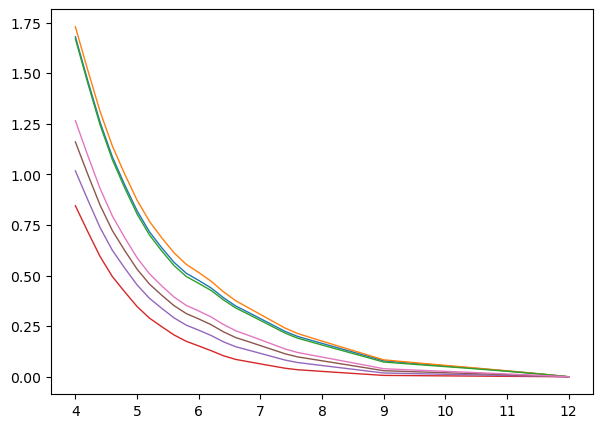

In [23]:
# Create data. Returns Q and z but z is always the same, so after we have z we only need [0] from func
dlim = 100
stem_clump = 'Data.nosync/Clumping Factor Data/'
stem_nion  = 'Data.nosync/Ndotion data/'
dmmlist = ['lambda', 'cold', 'hot', 'wdm1', 'wdm2', 'wdm3', 'wdm4']

plt.figure(figsize=(7, 5))

for dmm in dmmlist:
    clump_file = f'{dmm}/{dmm} Dlim {dlim} for CR correct alpha.txt'
    nion_file = f'Constant zeta dmm={dmm}.txt'
    Q, zarr = findQ(stem_clump + clump_file, stem_nion + nion_file)
    plt.plot(zarr, Q, linewidth=1.0, label=dmm)

# Constant clumping factor
clump_const = np.array([zarr, np.ones_like(zarr) * 3.0])
niondata    = np.transpose(np.loadtxt(nion_file))
Qarr_const  = odeint(dQdz, 0, zarr, args=(clump_const, niondata))[:,0]    # Solve diff. equation
plt.plot(zarr, Qarr_const, linewidth=1.0, label='const')

plt.xlim(np.min(zarr), np.max(zarr))
# plt.ylim(0., 1.)
plt.xlabel('$z$')
plt.ylabel('$Q$')
plt.legend()
# plt.savefig('Graphs/Plotting Ionisation Graphs/Odeint Defined C', dpi=300)
plt.show()

## Q vs z plots, $\Delta = 50$

50


<Figure size 700x500 with 0 Axes>

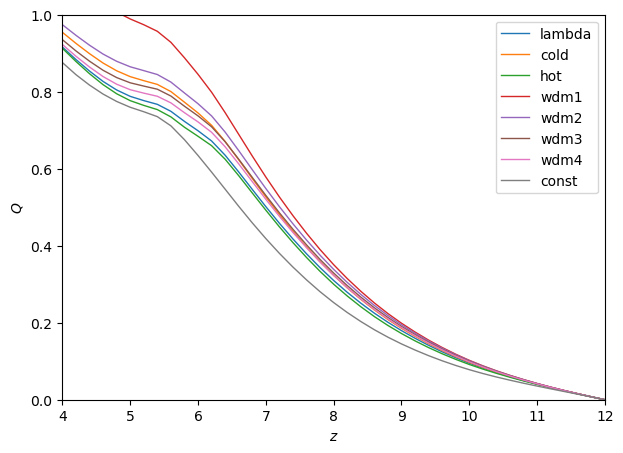

100


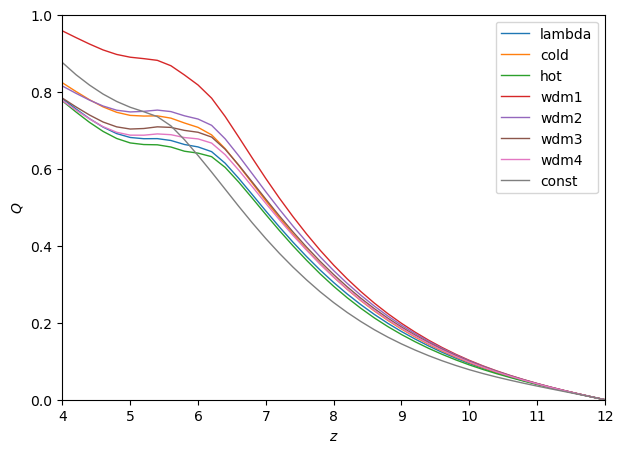

200


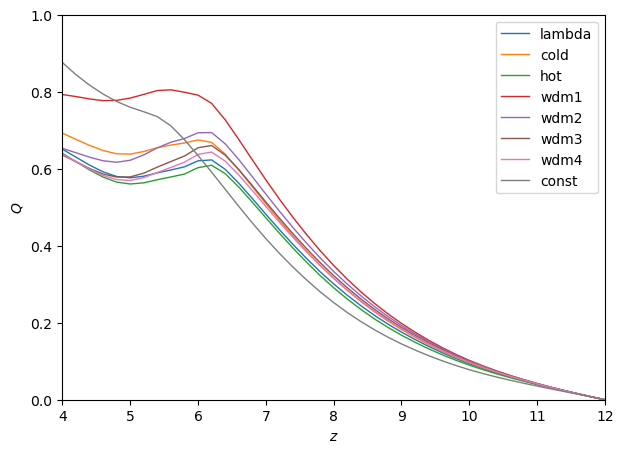

In [20]:
# Create data. Returns Q and z but z is always the same, so after we have z we only need [0] from func
dlim_list = [50, 100, 200]
stem = 'Data.nosync/Clumping Factor Data/'
nion_file = 'Data.nosync/Ndotion data/nion_kulkarni.txt'
dmmlist = ['lambda', 'cold', 'hot', 'wdm1', 'wdm2', 'wdm3', 'wdm4']

plt.figure(figsize=(7, 5))

for dlim in dlim_list:
    print(dlim)
    
    plt.figure(figsize=(7, 5))
    for dmm in dmmlist:
        file = f'{dmm}/{dmm} Dlim {dlim} for CR correct alpha.txt'
        Q, zarr = findQ(stem + file, nion_file)
        plt.plot(zarr, Q, linewidth=1.0, label=dmm)

    # Constant clumping factor
    clump_const = np.array([zarr, np.ones_like(zarr) * 3.0])
    niondata    = np.transpose(np.loadtxt(nion_file))
    Qarr_const  = odeint(dQdz, 0, zarr, args=(clump_const, niondata))[:,0]    # Solve diff. equation
    plt.plot(zarr, Qarr_const, linewidth=1.0, label='const')

    plt.xlim(np.min(zarr), np.max(zarr))
    plt.ylim(0., 1.)
    plt.xlabel('$z$')
    plt.ylabel('$Q$')
    plt.legend()
    plt.savefig(f'Graphs/Ionisation/Varying dmm/dlim={dlim} with constant C.jpg', dpi=300)
    plt.show()

## Q vs z plots, $\Delta = 200$

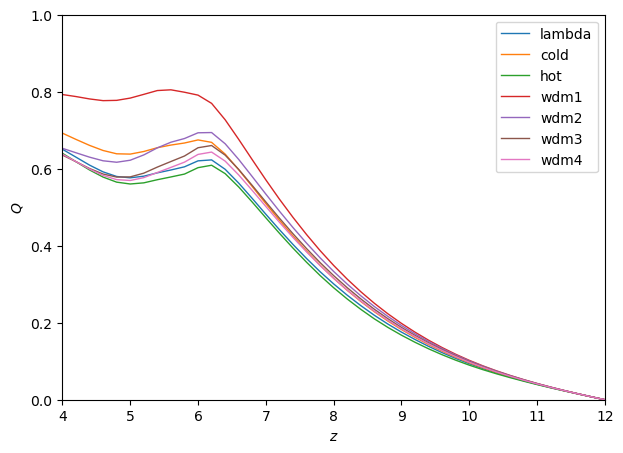

In [8]:
# Create data. Returns Q and z but z is always the same, so after we have z we only need [0] from func
dlim = 200
stem = 'Data.nosync/Clumping Factor Data/'
nion_file = 'Data.nosync/Ndotion data/nion_kulkarni.txt'
dmmlist = ['lambda', 'cold', 'hot', 'wdm1', 'wdm2', 'wdm3', 'wdm4']

plt.figure(figsize=(7, 5))

for dmm in dmmlist:
    file = f'{dmm}/{dmm} Dlim {dlim} for CR correct alpha.txt'
    Q, zarr = findQ(stem + file, nion_file)
    plt.plot(zarr, Q, linewidth=1.0, label=dmm)

plt.xlim(np.min(zarr), np.max(zarr))
plt.ylim(0., 1.)
plt.xlabel('$z$')
plt.ylabel('$Q$')
plt.legend()
# plt.savefig('Graphs/Plotting Ionisation Graphs/Odeint Defined C', dpi=300)
plt.show()

## Q vs z plots, ΛCDM, varying density limit

lambda


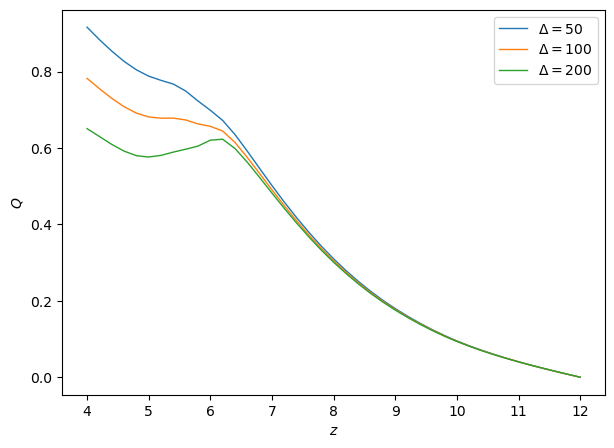

cold


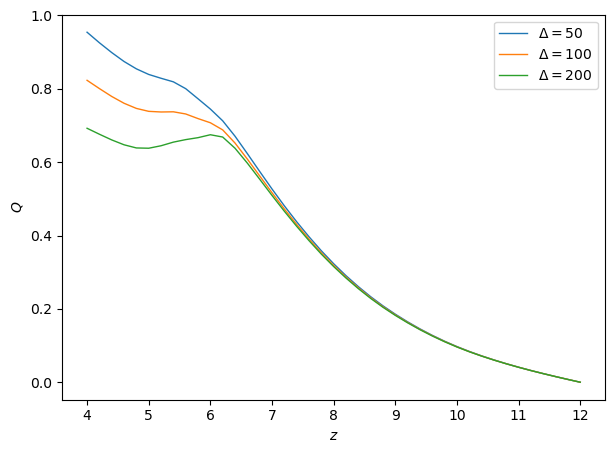

hot


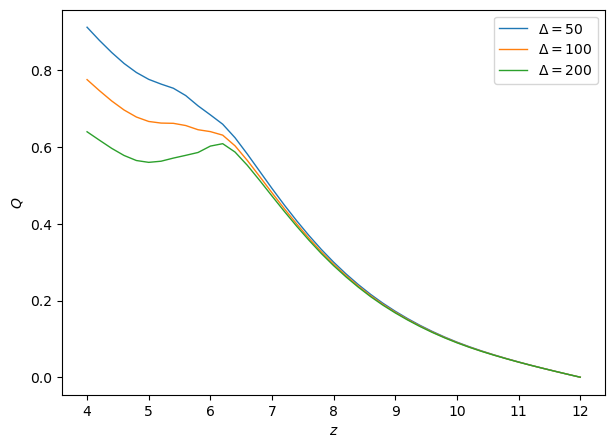

wdm1


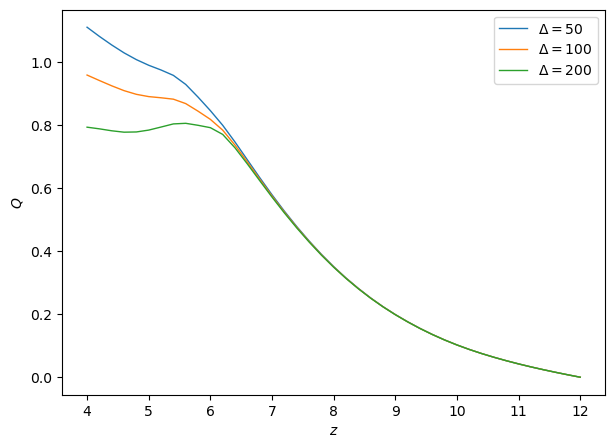

wdm2


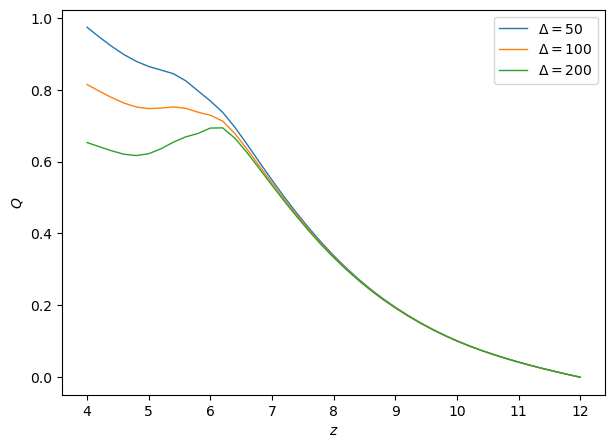

wdm3


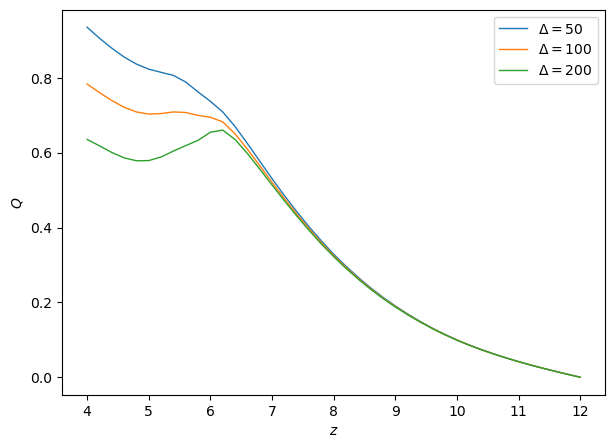

wdm4


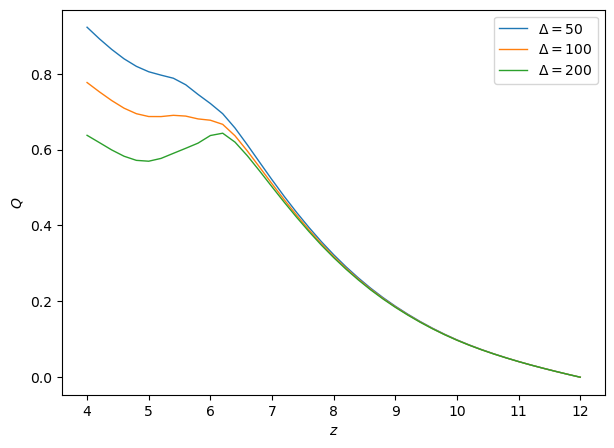

In [9]:
stem = 'Data.nosync/Clumping Factor Data/'
nion_file = 'Data.nosync/Ndotion data/nion_kulkarni.txt'

def vary_dlim(dmm):
    plt.figure(figsize=(7, 5))
    dlim_arr = [50, 100, 200]
    for dlim in dlim_arr:
        file = f'{dmm}/{dmm} Dlim {dlim} for CR correct alpha.txt'
        Q, zarr = findQ(stem + file, nion_file)
        plt.plot(zarr, Q, linewidth=1.0, label=f'$\\Delta = {dlim}$')
    plt.xlabel('$z$')
    plt.ylabel('$Q$')
    plt.legend()
    plt.savefig(f'Graphs/Ionisation/Varying Dlim/{dmm}.jpg', dpi=300)
    plt.show()

dmmlist = ['lambda', 'cold', 'hot', 'wdm1', 'wdm2', 'wdm3', 'wdm4']
for dmm in dmmlist:
    print(dmm)
    vary_dlim(dmm)